In [1]:
import ugradio
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import astropy.io.fits as pf
import lolfunctions
from astropy import units as u
import glob
import doppler
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
def peak_finder(signal_array, thresh):
    threshold = thresh*(999./1000)
    peaks = []                                                    
    for i in range(2,len(signal_array)-2): 
        if signal_array[i] > signal_array[i+1] and signal_array[i] > signal_array[i-1] and signal_array[i] > signal_array[i-2] and signal_array[i] > signal_array[i+2]:  
            if signal_array[i] > threshold: # or could do ==threshhold and set thresh = .max()                    
                peaks.append(i)
    return peaks

def centroid(x_range,y_range):
    '''A function to return the centroid given equally sized x and y ranges over which to perform the calculation'''
    x_range = np.array(x_range)
    y_range = np.array(y_range) 
    x = np.sum(x_range*y_range) 
    y = np.sum(y_range)
    x_centroid = x/y
    return x_centroid

def func(filename):
    lolavgs = np.array([])
    for i in np.arange(len(filename)):
        files_getdata = pf.getdata(filename[i])
        files_headers = pf.getheader(filename[i])
        files_open = pf.open(filename[i])
        
        nspec = files_headers['NSPEC']
        res = files_headers['RES']
        nchan = files_headers['NCHAN']
        
        avgs = np.zeros(len(files_getdata))
        for j in np.arange(nspec):
            specs = (files_open[j+1].data['auto1_real'])**2 + (files_open[j+1].data['auto0_real'])**2
            avgs = avgs + specs

        avgs = avgs/nspec
        meanavgs = avgs - np.mean(avgs)
        cutavgs = meanavgs[2500:-3500]
        if i == 0:
            lolavgs = np.append(lolavgs, cutavgs)
        else:
            lolavgs = np.vstack((lolavgs, cutavgs))
            
    return lolavgs

In [3]:
files635 = glob.glob('420_data_3/LO_635*.fits')
files636 = glob.glob('420_data_3/LO_636*.fits')

In [4]:
header635 = pf.getheader(files635[0])

In [5]:
avgs635 = np.loadtxt('avgs635_2')
avgs636 = np.loadtxt('avgs636_2')

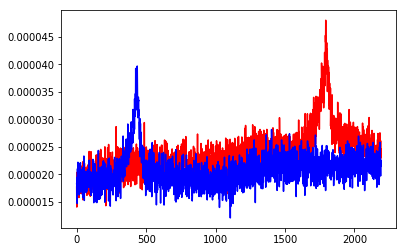

In [6]:
plt.plot(avgs635[0],'r')
plt.plot(avgs636[0],'b')

In [7]:
peaks = np.array([])
spectras635 =np.array([])
for i in np.arange(len(avgs635)):
    i = int(i)
    files_headers = pf.getheader(files635[i])

    nspec = files_headers['NSPEC']
    res = files_headers['RES']
    nchan = files_headers['NCHAN']

    cv635 = lolfunctions.airPLS(avgs635[i], lambda_= 50)[1200:,]
    cv636 = lolfunctions.airPLS(avgs636[i], lambda_= 50)[1200:,]
    
    flatavgs635 = avgs635[i][1200:,] - cv635
    flatavgs636 = avgs636[i][1200:,] - cv636
    
    sub = flatavgs635 - flatavgs636
    

    newsub = np.array([])
    for j in range(len(sub)):
        if j < 400 and sub[j] == max(sub[0:400]):
            newsub = np.append(newsub, 0)
        else:
            newsub = np.append(newsub, sub[j])
            

    newsub2 = np.array([])   
    for k in range(len(newsub)):
        if k < 400 and newsub[k] == max(newsub[0:400]):
            newsub2 = np.append(newsub2, 0)
        else:
            newsub2 = np.append(newsub2, newsub[k])
    
    if i == 0:
        spectras635 = np.append(spectras635, newsub2)
    else:
        spectras635 = np.vstack((spectras635, newsub2))
    
    LO = 635
    freqs = (np.arange(nchan) * res*u.Hz + 2 * LO * u.MHz + 144 * u.MHz).to(u.MHz).value[2500:-3500]

    fpeaks = peak_finder(newsub2, max(newsub2))
    
    cents = np.array([])
    for g in fpeaks:
        cents = np.append(cents, lolfunctions.centroid(freqs[1200:,][g-1:g+1],newsub2[g-1:g+1]))
        
    cents = np.mean(cents)
    #print(i,cents)
    peaks = np.append(peaks,cents)
#     plt.figure(figsize=(8,5))
#     plt.plot(freqs[1200:,], newsub2)
#     plt.axvline(cents)
#     plt.title(i, fontsize=17)
#     plt.xlabel('Frequency [MHZ]', fontsize=17)
#     plt.ylabel('Power', fontsize=17)
#     plt.grid(True)
#     plt.show()

In [8]:
gal_l = np.array([])
gal_b = np.array([])
RAs = np.array([])
DECs = np.array([])
JD = np.array([])

for i in np.arange(int(len(files635))):
    head = pf.getheader(files635[i])
    glon = head['L']
    glat = head['B']
    gal_l = np.append(gal_l,glon)
    gal_b = np.append(gal_b,glat)
    ra = head['RA']
    dec = head['DEC']
    RAs = np.append(RAs,ra)
    DECs = np.append(DECs,dec)
    jd = head['JD']
    JD = np.append(JD,jd)
    

In [10]:
v_corrected = []
for i in range(int(len(JD))):
    vel = doppler.get_projected_velocity(RAs[i],DECs[i],JD[i],obs_lat=37.9183, obs_lon=-122.1067, 
        obs_alt=304, epoch=2451545.)
    v_corrected.append(float(vel/1000))
    
f0 = 1420.4
c = 3e5 #km/s
df = peaks - f0
v = -(df/f0)*c


In [11]:
print(peaks[0])
print(v[0])

1420.28655653
23.9601809434


In [12]:
actual_v1 = v - v_corrected

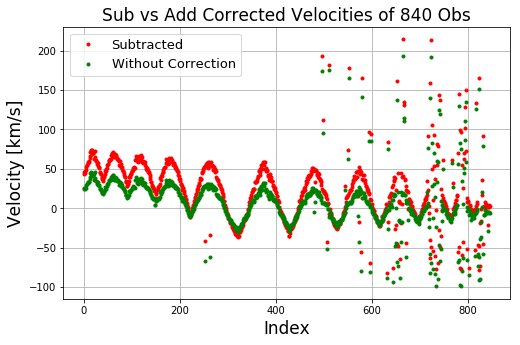

In [13]:
plt.figure(figsize=(8,5))
plt.plot(actual_v1,'r.')
plt.plot(v,'g.')
plt.legend(['Subtracted','Without Correction'],fontsize=13)
plt.ylabel('Velocity [km/s]',fontsize=17)
plt.xlabel('Index',fontsize=17)
plt.title('Sub vs Add Corrected Velocities of 840 Obs',fontsize=17)
plt.grid(True)
plt.show()

In [14]:
############################### FILES FROM OTHER NOTEBOOK ##############################
gal1 = np.loadtxt('totalgal')
gab1 = np.loadtxt('totalgab')
totalDEC1 = np.loadtxt('totalDEC1')
totalpeaks1 = np.loadtxt('totalpeaks1')
totalRA1 = np.loadtxt('totalRA1')
totalJD1 = np.loadtxt('totalJD1')
corrected_v1 = np.loadtxt('corrected_v1')

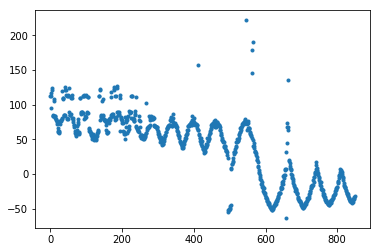

In [15]:
plt.plot(corrected_v1,'.')

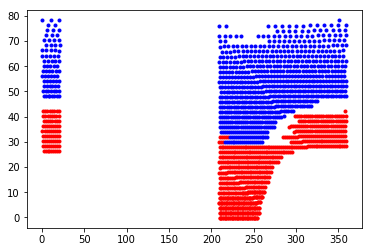

In [16]:
plt.plot(gal1, gab1, 'r.')
plt.plot(gal_l,gal_b, 'b.')
plt.show()

In [17]:
total_gal = np.concatenate((gal_l,gal1),axis=0)
total_gab = np.concatenate((gal_b,gab1),axis=0)

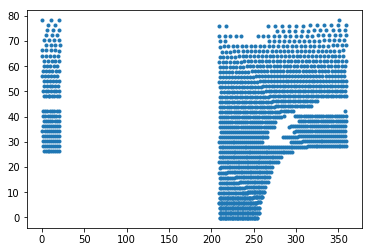

In [18]:
plt.plot(total_gal,total_gab,'.')

In [19]:
total_vel = np.concatenate((actual_v1, corrected_v1),axis=0)


In [20]:
print('Max Long index = ',np.argmax(total_gal))
print('Min Long index = ', np.argmin(total_gal))
print('Max Long Value = ', max(total_gal))
print('Min Long Value = ', min(total_gal))

print('Max Lat index = ',np.argmax(total_gab))
print('Min Lat index = ', np.argmin(total_gab))
print('Max Lat Value = ', max(total_gab))
print('Min Lat Value = ', min(total_gab))

('Max Long index = ', 1632)
('Min Long index = ', 522)
('Max Long Value = ', 359.54822969025372)
('Min Long Value = ', 0.053678555762598057)
('Max Lat index = ', 843)
('Min Lat index = ', 981)
('Max Lat Value = ', 78.22139931246295)
('Min Lat Value = ', -0.2033097168162194)


In [22]:
l_ran = max(total_gal) - min(total_gal)
b_ran = max(total_gab) - min(total_gab)
print(l_ran)
print(b_ran)

grid = np.array([])
for i in np.arange(360):
    if i == 0:
        grid = np.append(grid, np.zeros(79))
    else:
        grid = np.vstack((grid, np.zeros(79)))

359.494551134
78.4247090293


In [23]:
x = np.linspace(0,79,1696)
y = np.linspace(0,360,1696)

In [24]:

print total_vel.shape
print x.shape
print y.shape

grid = np.array([])
for i in np.arange(360):
    if i ==0:
        grid = np.append(grid, np.zeros(80))
    else:
        grid = np.vstack((grid,np.zeros(80)))

(1696L,)
(1696L,)
(1696L,)


In [212]:
from aipy.healpix import HealpixMap

ImportError: No module named aipy.healpix

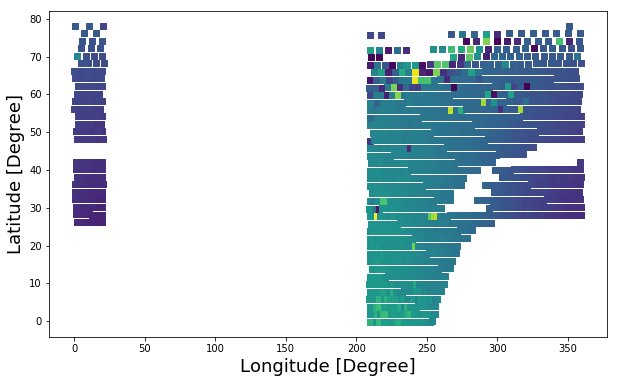

In [31]:
plt.figure(figsize=(10,6))
plt.scatter(total_gal,total_gab, c=total_vel,marker=',')
plt.xlabel('Longitude [Degree]', fontsize=18)
plt.ylabel('Latitude [Degree]', fontsize=18)
plt.show()

In [26]:

vlb_dict = {} #velocity: long, lat
for i in range(len(total_vel)):
    vlb_dict[total_vel[i]] = total_gal[i], total_gab[i]

In [27]:
vlb_dict

{48.537826581981342: (216.85872182100439, 55.809108497621366),
 -8.5875281977954199: (319.39094534741298, 40.15189105231277),
 5.3948612497673762: (313.56682993341099, 60.134970600810348),
 -6.7579993920661661: (327.69471882764498, 56.173770434759277),
 50.269562158682092: (244.3595982960428, 45.88301053098283),
 39.386780956325737: (265.46016303628812, 21.958555783225709),
 1.3869953225911749: (328.21307687475593, 64.175104076867143),
 -9.2785984441309903: (313.57411606682672, 36.134700942344182),
 24.124116088516146: (277.80814536517829, 52.006521853365832),
 72.076176664481181: (226.66301587531771, 21.831061734055609),
 67.80020660938662: (236.87166194546779, 15.8592254555103),
 78.892553312253327: (243.1044069368107, 5.8786515935080637),
 -42.563931406937414: (17.368277975664199, 38.21777040647072),
 113.66055901568488: (235.92473608146349, 3.8563764337773652),
 80.814459501844794: (211.29564018116051, 9.7989391050954477),
 -22.644735462320018: (351.80364706913798, 50.2149373420934

In [28]:
vlb_dict.keys()[0]

48.537826581981342

In [29]:
vlb_dict.values()[0]

(216.85872182100439, 55.809108497621366)

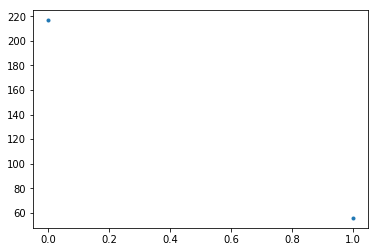

In [32]:
plt.plot(vlb_dict.values()[0], '.')

In [34]:
grid=np.array([])
for i in np.arange(len(total_gab)):
    if i == 0:
        grid = np.append(grid, np.zeros(len(total_gal)))
    else:
        grid = np.vstack((grid, np.zeros(len(total_gal))))

In [38]:
print grid[0]  + 1

[ 1.  1.  1. ...,  1.  1.  1.]
